In [ ]:
!pip3 install gymnasium[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.7 MB/s eta 0:00:00


# Import Libraries

In [ ]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("Acrobot-v1", render_mode = "rgb_array")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
import imageio
# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Env Info

In [ ]:

# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n


In [ ]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  6
Sample observation [ -0.6781949    0.6355308   -0.33520743   0.45147428  -6.4637303
 -18.86979   ]


In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

The Action Space is:  3
Action Space Sample 0


# DQN

In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 32)
        self.layer2 = nn.Linear(32,128)
        self.layer3 = nn.Linear(128, 256)
        self.layer4 = nn.Linear(256, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)

## Create Replay Buffer

Replay buffer is a queue of transition:

each transtion is : $(s_t, a, s_{t+1}, r)$

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


# Train

In [ ]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 512
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 10000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
print(n_actions, len(state))
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)



steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            #print(policy_net(state).shape)
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)



3 6


In [ ]:
# episode_durations = []


def plot_reward(reawards_list, show_result = False):
    plt.figure(1)
    reward_t = torch.tensor(reawards_list, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(reward_t.numpy())
    # Take 100 episode averages and plot them too
    if len(reward_t) >= 20:
        means = reward_t.unfold(0, 20, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(19), means))
        plt.plot(means.numpy(), label='Mean Rewards')

        # Calculate variance and confidence interval
        stds = reward_t.unfold(0, 20, 1).std(1).view(-1)
        stds = torch.cat((torch.zeros(19), stds))
        upper_bound = means + 1.96 * stds / np.sqrt(20)  # 95% confidence interval
        lower_bound = means - 1.96 * stds / np.sqrt(20)

        # Plot variance with confidence interval
        plt.fill_between(range(len(means)), lower_bound.numpy(), upper_bound.numpy(), alpha=0.3, color='orange', label='Confidence Interval (95%)')

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

# def plot_reward(rewards, show_result=False):
#     plt.figure(1)
#     durations_t = torch.tensor(rewards, dtype=torch.float)
#     if show_result:
#         plt.title('Result')
#     else:
#         plt.clf()
#         plt.title('Training...')
#     plt.xlabel('Episode')
#     plt.ylabel('Duration')
#     plt.plot(durations_t.numpy())
#     # Take 100 episode averages and plot them too
#     if len(durations_t) >= 20:
#         means = durations_t.unfold(0, 20, 1).mean(1).view(-1)
#         means = torch.cat((torch.zeros(19), means))
#         plt.plot(means.numpy())

#     plt.pause(0.001)  # pause a bit so that plots are updated
#     if is_ipython:
#         if not show_result:
#             display.display(plt.gcf())
#             display.clear_output(wait=True)
#         else:
#             display.display(plt.gcf())

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


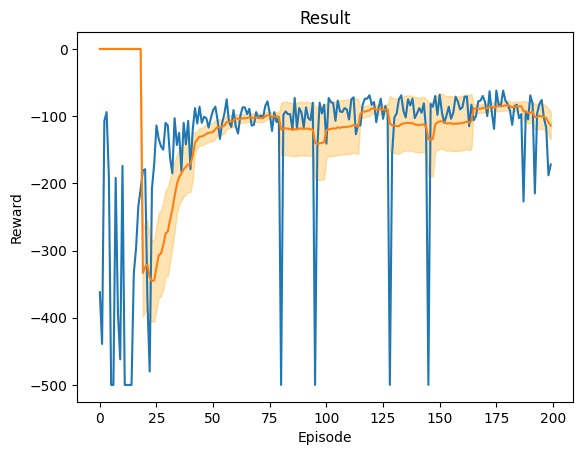

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
trial_rewards = []
TRIALS = 5
for t in range(TRIALS):


    policy_net = DQN(n_observations, n_actions).to(device)
    target_net = DQN(n_observations, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
    memory = ReplayMemory(10000)


    if torch.cuda.is_available():
        num_episodes = 200
    else:
        num_episodes = 50
    episods_reward = []
    for i_episode in range(num_episodes):
        episode_reward = 0
        # Initialize the environment and get it's state
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        for t in count():
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated
            episode_reward += reward
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episods_reward.append(episode_reward)
                #plot_reward(episods_reward)
                break
    trial_rewards.append(episods_reward)

print('Complete')
plot_reward(episods_reward,show_result=True)
plt.ioff()
plt.show()

In [ ]:
rewards_seq_numpy = np.array([[tensor.cpu().numpy() for tensor in sublist] for sublist in trial_rewards])
rewards_seq_numpy = rewards_seq_numpy.squeeze()
rewards_seq_numpy.shape

(5, 200)

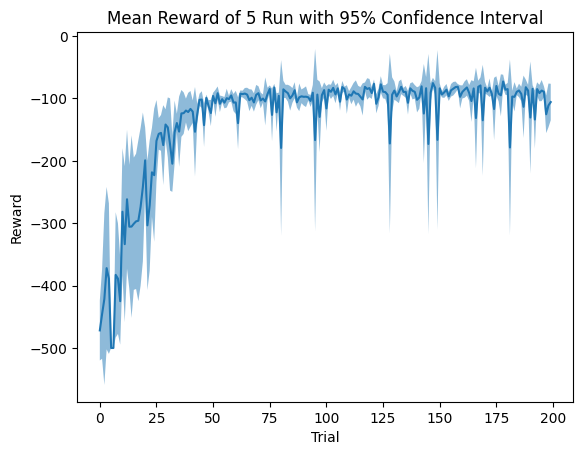

In [ ]:

mean_reward = np.mean(rewards_seq_numpy, axis=0)
std_reward = np.std(rewards_seq_numpy, axis=0)

# Calculate the confidence interval for the mean regret
upper_bound = mean_reward + 1.96 * std_reward / np.sqrt(rewards_seq_numpy.shape[0])
lower_bound = mean_reward - 1.96 * std_reward / np.sqrt(rewards_seq_numpy.shape[0])

# Plot the mean regret and confidence interval
fig, ax = plt.subplots()
ax.plot(mean_reward, label="Mean Reward")
ax.fill_between(np.arange(len(mean_reward)), lower_bound ,upper_bound , alpha=0.5, label="Confidence Interval")

# Set the title and labels
ax.set_title("Mean Reward of 5 Run with 95% Confidence Interval")
ax.set_xlabel("Trial")
ax.set_ylabel("Reward")

# Show the plot
plt.show()

# Video

In [ ]:
def record_video(env, policy, out_directory, fps=5):
  """
  Generate a replay video of the agent
  :param env
  :param Policy: Deep Q value Estimator of our agent
  :param out_directory
  :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
  """
  images = []
  done = False
  state, info = env.reset()
#   img = env.render(mode='rgb_array')
  img = env.render()
  print(img.shape)
  images.append(img)
  c= 0
  terminated = False
  while (not terminated):
    # Take the action (index) that have the maximum expected future reward given that state
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    action = select_action(state)
    observation, reward, terminated, truncated, _  = env.step(action) # We directly put next_state = state for recording logic
    if terminated:
        next_state = None
    else:
        next_state = observation
    state = next_state
    img = env.render()
    images.append(img)
    c+=1
  imageio.mimsave(out_directory + '.mp4', [np.array(img) for i, img in enumerate(images)], fps=fps)


In [ ]:
video_path = 'try1'
record_video(env, target_net, video_path, 30)
from IPython.display import Video
Video('/content/'+video_path +'.mp4', embed=True)

(500, 500, 3)
